In [12]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from os import path
from utils import plot_report

import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 20.0]
HDFStore=pd.HDFStore

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np

import config

In [13]:
# loading data parameters
num_coefficients=17

# training parameters
seed= config.seed

dr=0.2
lr2=1e-3
lr1=1e-4
lr=8e-4

num_epochs=1000
mini_batch_size=4

main_units=64
secondary_units=16
last_unit=8
lstm_units=64
num_classes=3


print_sample=False

In [14]:
score = 'accuracy'

#this data has been previously processed by airflow
features = pd.read_csv("/data/elekin/data/results/handwriting/residues_17_20220901.csv") #TODO automate
features = features.set_index(features.columns[0]).sort_index()
print("Loaded data from CSV")
features.head(10)

Loaded data from CSV


0          1          2          3          4  \
subject_id                                                             
C01_1       7.349452e-15 -13.291940   1.024601  10.161138   3.315941   
C01_2       6.756754e-14 -31.209053  -0.017404  17.752622   1.237945   
C02_1       3.542767e-14 -60.542107 -27.549071  22.667162  29.774608   
C02_2       0.000000e+00 -27.968298   3.847043  19.568139   4.392351   
C03_1      -1.448672e-13 -24.217525   0.030620  15.214947   2.708331   
C03_2      -3.216604e-14  -4.743053   2.357251   4.825403   1.856053   
C04_1       1.275924e-14 -19.238670   4.887121   9.269133  -5.603701   
C04_2      -8.748646e-14  -6.639625   7.783162  -1.958290  -0.019630   
C05_1       0.000000e+00 -27.907347  10.881926  10.252521 -11.110835   
C05_2       7.349452e-14 -55.604800  20.513907  23.606124 -18.830307   

                   5          6          7          8          9  ...  \
subject_id                                                        ...   
C01_1      -3.097414   1.440666   7.129718   4.707049   0.572884  ...   
C01_2      -9.987982   2.213369  11.402657   2.611116  -4.204175  ...   
C02_1      -0.049968 -21.247772 -10.065639  13.253232  17.932418  ...   
C02_2      -0.129432  17.771599  29.816480  28.274217  34.182908  ...   
C03_1      -8.058323   0.193426   9.060716   3.685560  -3.239162  ...   
C03_2       3.416943   9.272533  11.910841  11.251721  11.652002  ...   
C04_1      -4.442068   5.761753   2.020816  -4.567960   0.597289  ...   
C04_2       4.697744  -0.645690   3.079784   4.094312   2.093642  ...   
C05_1      -1.430228   9.070397  -2.783219  -4.909954   5.666420  ...   
C05_2      -2.147895  23.407910   2.729305  -6.065415  16.906241  ...   

                  4086        4087        4088        4089        4090  \
subject_id                                                               
C01_1        97.448900   95.955542  101.818591  104.332167   95.874072   
C01_2       222.096143  213.065104  221.689744  232.912255  220.952794   
C02_1       344.367840  374.472317  380.804964  362.103375  356.832894   
C02_2       214.985799  204.703211  209.397646  222.910419  215.988709   
C03_1       110.591346  104.897082  115.563854  127.342230  121.951827   
C03_2        36.862525   35.561624   34.204905   36.363264   37.555728   
C04_1        77.518802   72.292842   64.360034   75.220587   89.323213   
C04_2        82.562342   79.182332   82.388434   82.390361   78.429148   
C05_1       107.457379  118.450235  114.096347  128.871858  158.741696   
C05_2       361.785103  370.503431  351.812399  371.606643  408.219804   

                  4091        4092        4093        4094        4095  
subject_id                                                              
C01_1        89.940103  101.853141  116.800260  101.116099   49.724857  
C01_2       204.349330  222.760910  255.393283  225.934430  113.379869  
C02_1       397.935247  458.875221  461.692858  352.041872  164.092353  
C02_2       197.589052  209.616093  241.172176  216.979362  109.734380  
C03_1       117.953167  145.015919  181.972929  167.326704   85.417298  
C03_2        34.273989   33.939043   40.137283   39.286630   21.104560  
C04_1        86.753011   95.350440  133.114825  143.943629   80.689566  
C04_2        85.139955   80.384840   77.471092   93.832116   63.282700  
C05_1       158.948752  160.007117  212.835150  236.414668  134.861681  
C05_2       384.900525  373.373731  458.582007  478.112670  264.588415  

[10 rows x 4096 columns]

In [15]:
labels = pd.read_csv("/data/elekin/data/results/handwriting/level_20220901.csv", index_col=0).sort_index()
labels.head(10)

level
name        
C01_1      0
C01_2      0
C02_1      0
C02_2      0
C03_1      0
C03_2      0
C04_1      0
C04_2      0
C05_1      0
C05_2      0

In [16]:
np.array_equal(features.index.values, labels.index.values)

True

In [17]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(labels).astype(np.int16)
y.shape
#binary labels
#le = LabelEncoder().fit(labels.values.ravel())
#y = le.fit_transform(labels.values.ravel()).astype(np.int16)
#y

(53, 3)

In [18]:
X=features.values.astype(np.float64)
X.shape

(53, 4096)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=38)

In [20]:
y_test

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1]], dtype=int16)

In [21]:
x_train.shape, x_test.shape

((35, 4096), (18, 4096))

In [22]:
num_features = x_train.shape[1]

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

if print_sample:
    for feat, targ in test_dataset.take(10):
        print ('Features test: {}, Target: {}'.format(feat, targ))

    for feat, targ in test_dataset.take(10):
        print ('Features train: {}, Target: {}'.format(feat, targ))

print("{0} train batches and {1} test batches of {2} mini batch size and {3} steps per epoch".format(len(train_dataset), 
                                                                              len(test_dataset),
                                                                              mini_batch_size,
                                                                                steps_per_epoch))

9 train batches and 5 test batches of 4 mini batch size and 2 steps per epoch


## FCNN ARCHITECTURE ANALISYS

Some training helpers functions

In [26]:
# #Early stop configuration
earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=1e-3,
  patience=200)

training_earlystop_callback = EarlyStopping(
  monitor='accuracy', min_delta=1e-4,
  patience=200)

def get_callbacks(name):
    return [
        #tfdocs.modeling.EpochDots(),
        earlystop_callback,
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-5),
        #tf.keras.callbacks.TensorBoard(logdir/name),
      ]

def compile_and_fit(model, train_dataset, test_dataset, name, optimizer=None, max_epochs=1000):
    tf.keras.backend.clear_session()# avoid clutter from old models and layers, especially when memory is limited
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    tf.random.set_seed(seed) # establecemos la semilla para tensorflow
    history = model.fit(train_dataset, 
                        use_multiprocessing=True, 
                        validation_data=test_dataset, epochs=max_epochs, 
                        callbacks=get_callbacks(name),
                        verbose=1, shuffle=False)
    return history

# Many models train better if you gradually reduce the learning rate during training. 
# Use optimizers.schedules to reduce the learning rate over time:
def get_optimizer(steps_per_epoch=1, lr=1e-4, multiplier=1000):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(lr,
                                                                 decay_steps=steps_per_epoch*multiplier,
                                                                 decay_rate=1,
                                                                 staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)

In [16]:
size_histories = {}

In [17]:
tiny = tf.keras.models.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)])

size_histories['fcnn/tiny'] = compile_and_fit(tiny, train_dataset, 
                                              test_dataset,
                                              "fcnn/tiny", 
#                                               optimizer=get_optimizer(),
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 262,403
Trainable params: 262,403
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
9/9 [==============================] - 1s 13ms/step - loss: 4.0918 - accuracy: 0.4571 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 2/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 4/1000
9/9 [=======

9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 55/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 56/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 57/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 58/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 59/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 60/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 61/1000
9/9 [========

9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 113/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 114/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 115/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 116/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 117/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 118/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 119/1000
9/9 [=

Epoch 170/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 171/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 172/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 173/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 174/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 175/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 176/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.5429 - val_loss: 1.0986 - val_accuracy: 0.7222
Epoch 

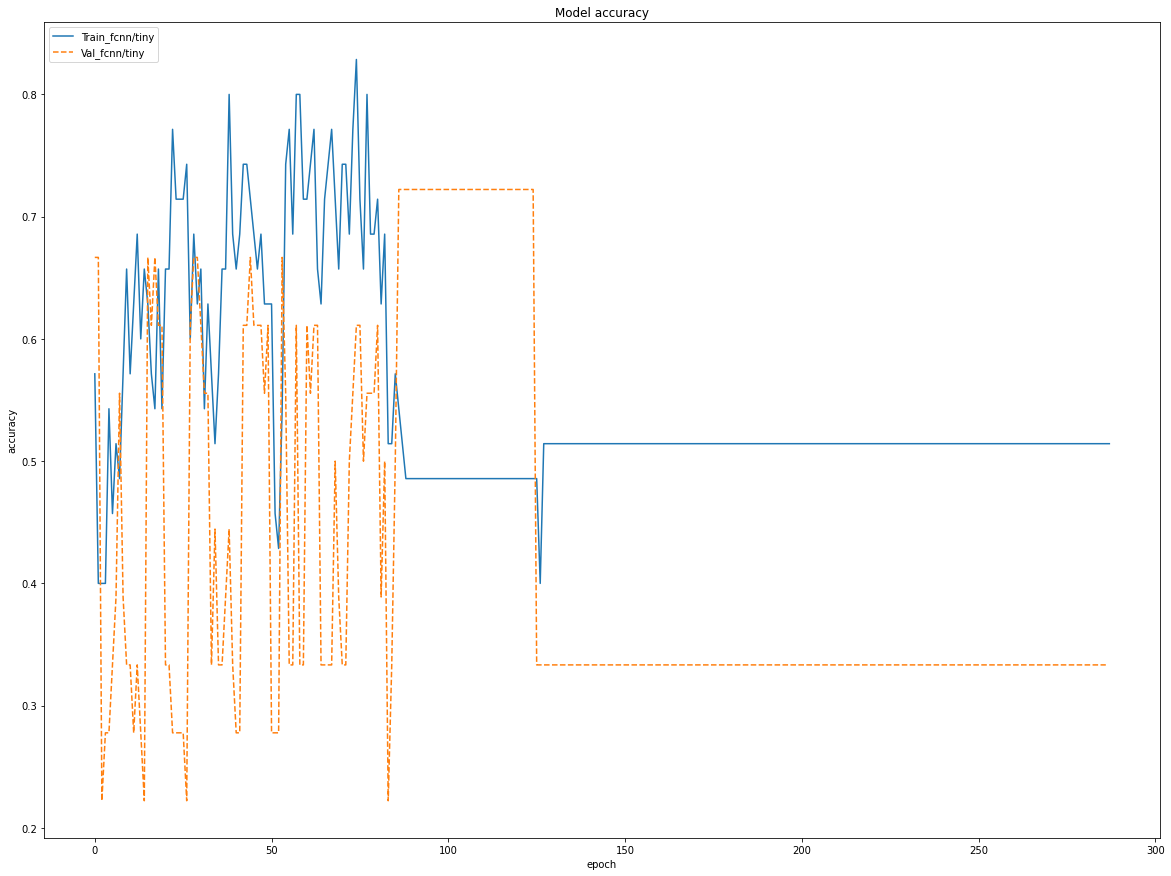

In [16]:
mpl.rcParams['figure.figsize'] = [20.0, 15.0]
plot_report(size_histories, metric='accuracy')

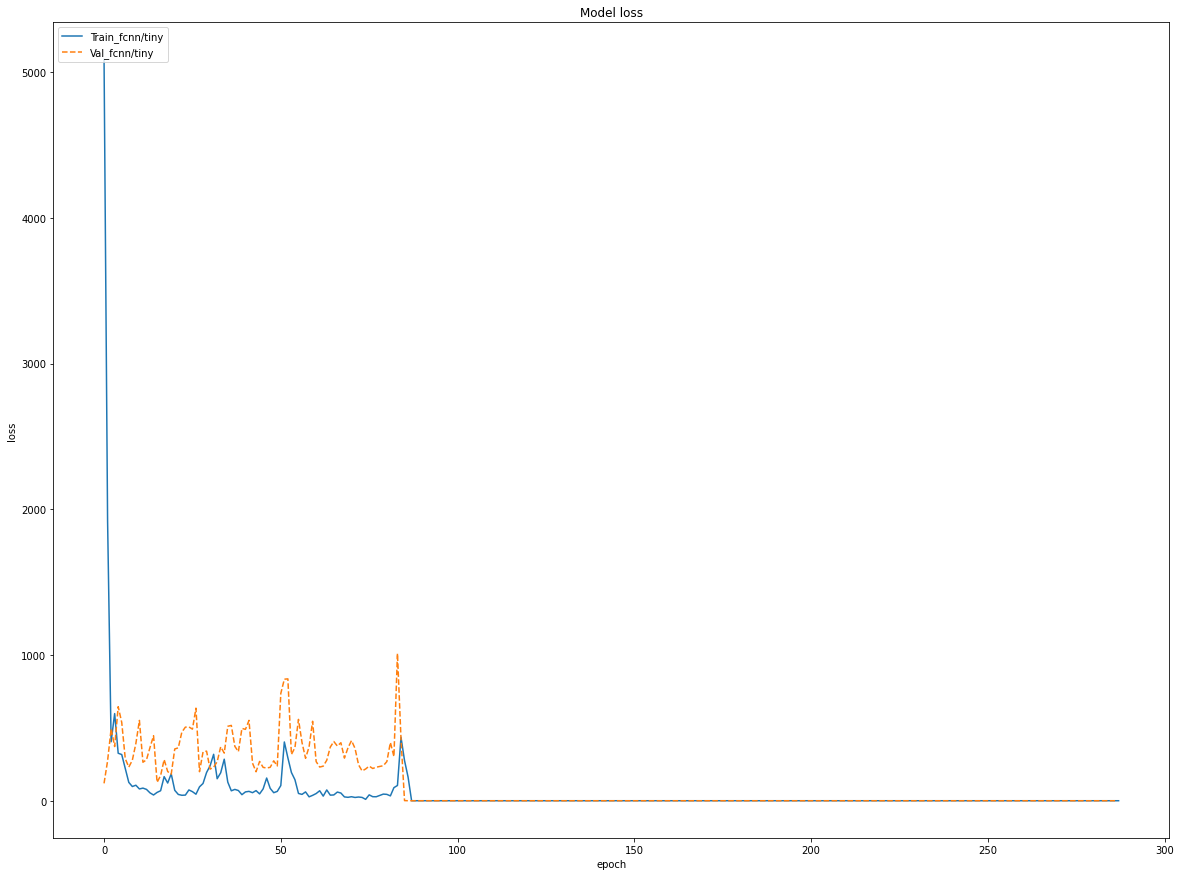

In [17]:
plot_report(size_histories, 'loss')

In [18]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/small'] = compile_and_fit(small_model, train_dataset, 
                                              test_dataset,'fcnn/small',
#                                               optimizer=get_optimizer(),
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/small'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/small'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 263,265
Trainable params: 263,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
9/9 [==============================] - 0s 10ms/step - loss: 439.8944 - accuracy: 0.5714 - val_loss: 133.7621 - val_accuracy: 0.6667
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 361.6789 - accuracy: 0.4571 - val_loss: 274.0406 - val_accuracy: 0.6667
Epoch 3/1000
9/9 [=======

Epoch 52/1000
9/9 [==============================] - 0s 3ms/step - loss: 322.6878 - accuracy: 0.7429 - val_loss: 541.7827 - val_accuracy: 0.6111
Epoch 53/1000
9/9 [==============================] - 0s 3ms/step - loss: 323.2102 - accuracy: 0.6000 - val_loss: 536.9836 - val_accuracy: 0.6667
Epoch 54/1000
9/9 [==============================] - 0s 2ms/step - loss: 219.6754 - accuracy: 0.6857 - val_loss: 1517.1827 - val_accuracy: 0.2778
Epoch 55/1000
9/9 [==============================] - 0s 3ms/step - loss: 193.3238 - accuracy: 0.7429 - val_loss: 526.2695 - val_accuracy: 0.6667
Epoch 56/1000
9/9 [==============================] - 0s 3ms/step - loss: 61.4572 - accuracy: 0.6857 - val_loss: 520.9050 - val_accuracy: 0.6111
Epoch 57/1000
9/9 [==============================] - 0s 7ms/step - loss: 96.4806 - accuracy: 0.6571 - val_loss: 1128.8364 - val_accuracy: 0.3333
Epoch 58/1000
9/9 [==============================] - 0s 3ms/step - loss: 157.2619 - accuracy: 0.7143 - val_loss: 708.1413 - val_ac

Epoch 109/1000
9/9 [==============================] - 0s 2ms/step - loss: 65.5689 - accuracy: 0.8286 - val_loss: 351.2167 - val_accuracy: 0.5556
Epoch 110/1000
9/9 [==============================] - 0s 2ms/step - loss: 59.6108 - accuracy: 0.6857 - val_loss: 344.3912 - val_accuracy: 0.5556
Epoch 111/1000
9/9 [==============================] - 0s 3ms/step - loss: 84.8764 - accuracy: 0.6571 - val_loss: 413.2199 - val_accuracy: 0.6111
Epoch 112/1000
9/9 [==============================] - 0s 2ms/step - loss: 59.0421 - accuracy: 0.8000 - val_loss: 532.8930 - val_accuracy: 0.3333
Epoch 113/1000
9/9 [==============================] - 0s 2ms/step - loss: 59.7331 - accuracy: 0.7714 - val_loss: 551.5996 - val_accuracy: 0.3333
Epoch 114/1000
9/9 [==============================] - 0s 2ms/step - loss: 63.2780 - accuracy: 0.7714 - val_loss: 700.2627 - val_accuracy: 0.2778
Epoch 115/1000
9/9 [==============================] - 0s 2ms/step - loss: 62.9838 - accuracy: 0.8286 - val_loss: 411.8568 - val_ac

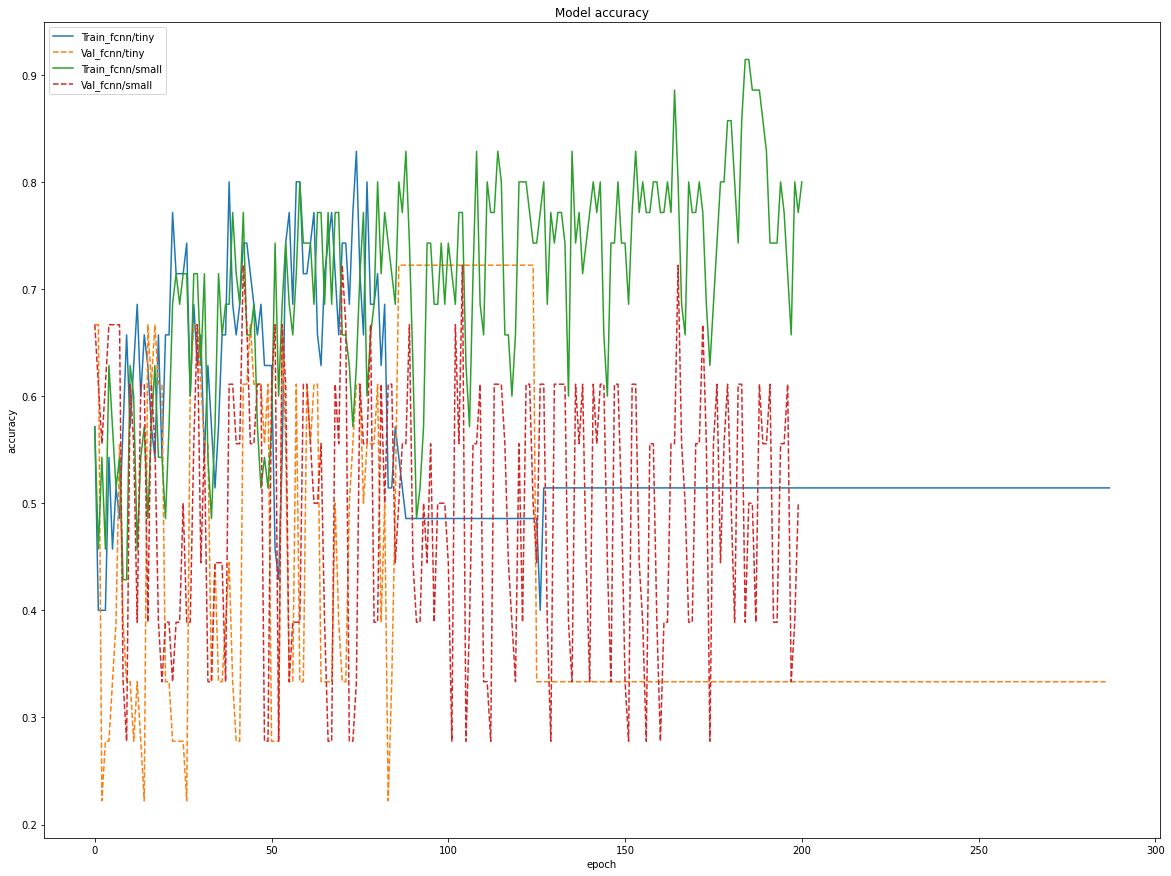

In [19]:
plot_report(size_histories)

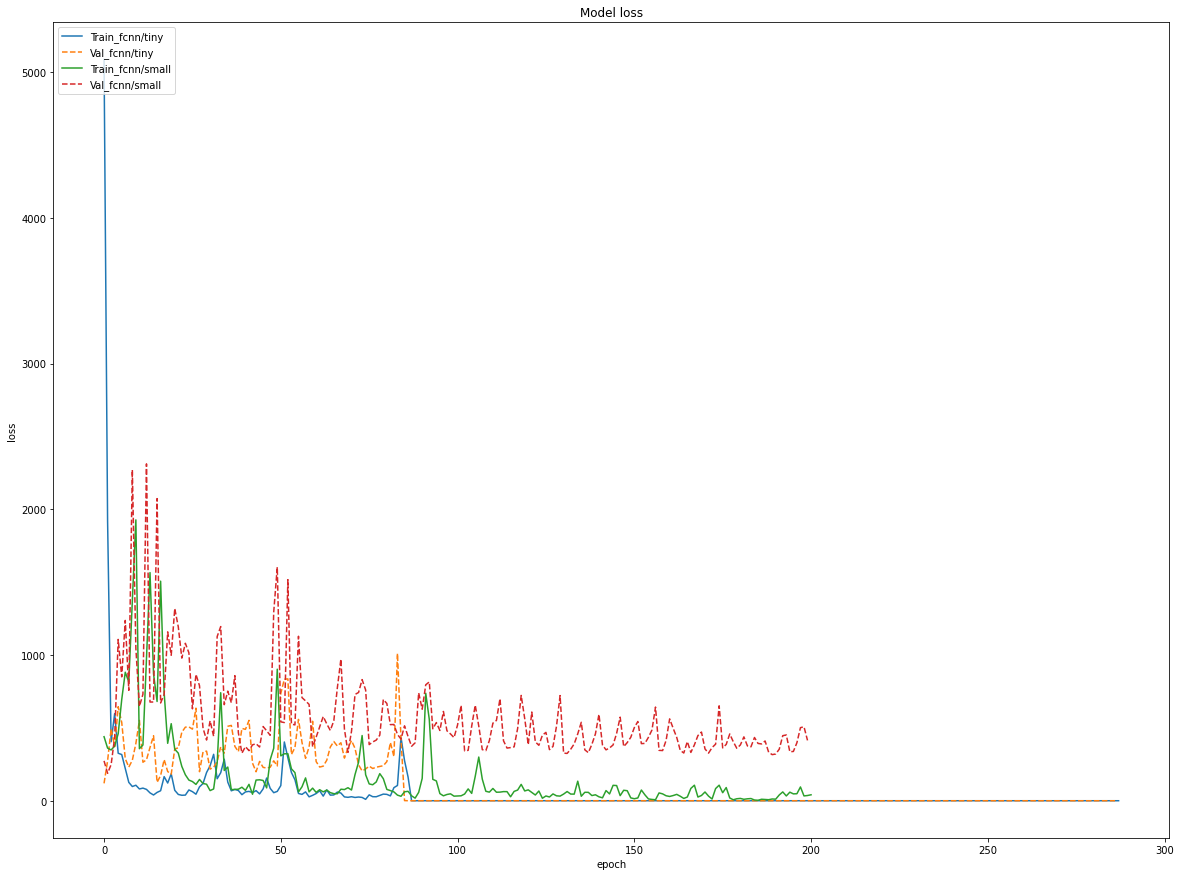

In [20]:
plot_report(size_histories, 'loss')

In [21]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),  
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/large'] = compile_and_fit(large_model, train_dataset, 
                                              test_dataset, "fcnn/large",
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer=get_optimizer(), 
                                              max_epochs=num_epochs)

print("Evaluation")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/large'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/large'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 267,553
Trainable params: 267,553
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
9/9 [==============================] 

Epoch 51/1000
9/9 [==============================] - 0s 2ms/step - loss: 11.7411 - accuracy: 0.6000 - val_loss: 13.1787 - val_accuracy: 0.6667
Epoch 52/1000
9/9 [==============================] - 0s 2ms/step - loss: 9.8102 - accuracy: 0.6571 - val_loss: 26.7112 - val_accuracy: 0.5000
Epoch 53/1000
9/9 [==============================] - 0s 2ms/step - loss: 5.2557 - accuracy: 0.7143 - val_loss: 20.1217 - val_accuracy: 0.6667
Epoch 54/1000
9/9 [==============================] - 0s 3ms/step - loss: 12.0400 - accuracy: 0.6571 - val_loss: 40.1892 - val_accuracy: 0.3333
Epoch 55/1000
9/9 [==============================] - 0s 2ms/step - loss: 4.8892 - accuracy: 0.7143 - val_loss: 42.2226 - val_accuracy: 0.3333
Epoch 56/1000
9/9 [==============================] - 0s 2ms/step - loss: 4.6932 - accuracy: 0.6857 - val_loss: 41.3191 - val_accuracy: 0.3333
Epoch 57/1000
9/9 [==============================] - 0s 2ms/step - loss: 3.7313 - accuracy: 0.7714 - val_loss: 37.9007 - val_accuracy: 0.2778
Epoc

9/9 [==============================] - 0s 2ms/step - loss: 16.7946 - accuracy: 0.5429 - val_loss: 36.8735 - val_accuracy: 0.6111
Epoch 166/1000
9/9 [==============================] - 0s 2ms/step - loss: 116.4925 - accuracy: 0.4571 - val_loss: 18.3904 - val_accuracy: 0.7222
Epoch 167/1000
9/9 [==============================] - 0s 3ms/step - loss: 41.9143 - accuracy: 0.4286 - val_loss: 26.8956 - val_accuracy: 0.6667
Epoch 168/1000
9/9 [==============================] - 0s 2ms/step - loss: 60.0308 - accuracy: 0.4000 - val_loss: 25.7429 - val_accuracy: 0.3333
Epoch 169/1000
9/9 [==============================] - 0s 2ms/step - loss: 13.2124 - accuracy: 0.4857 - val_loss: 7.9926 - val_accuracy: 0.6667
Epoch 170/1000
9/9 [==============================] - 0s 2ms/step - loss: 5.7351 - accuracy: 0.4000 - val_loss: 4.5214 - val_accuracy: 0.6667
Epoch 171/1000
9/9 [==============================] - 0s 2ms/step - loss: 24.9386 - accuracy: 0.4857 - val_loss: 6.0768 - val_accuracy: 0.6667
Epoch 172/

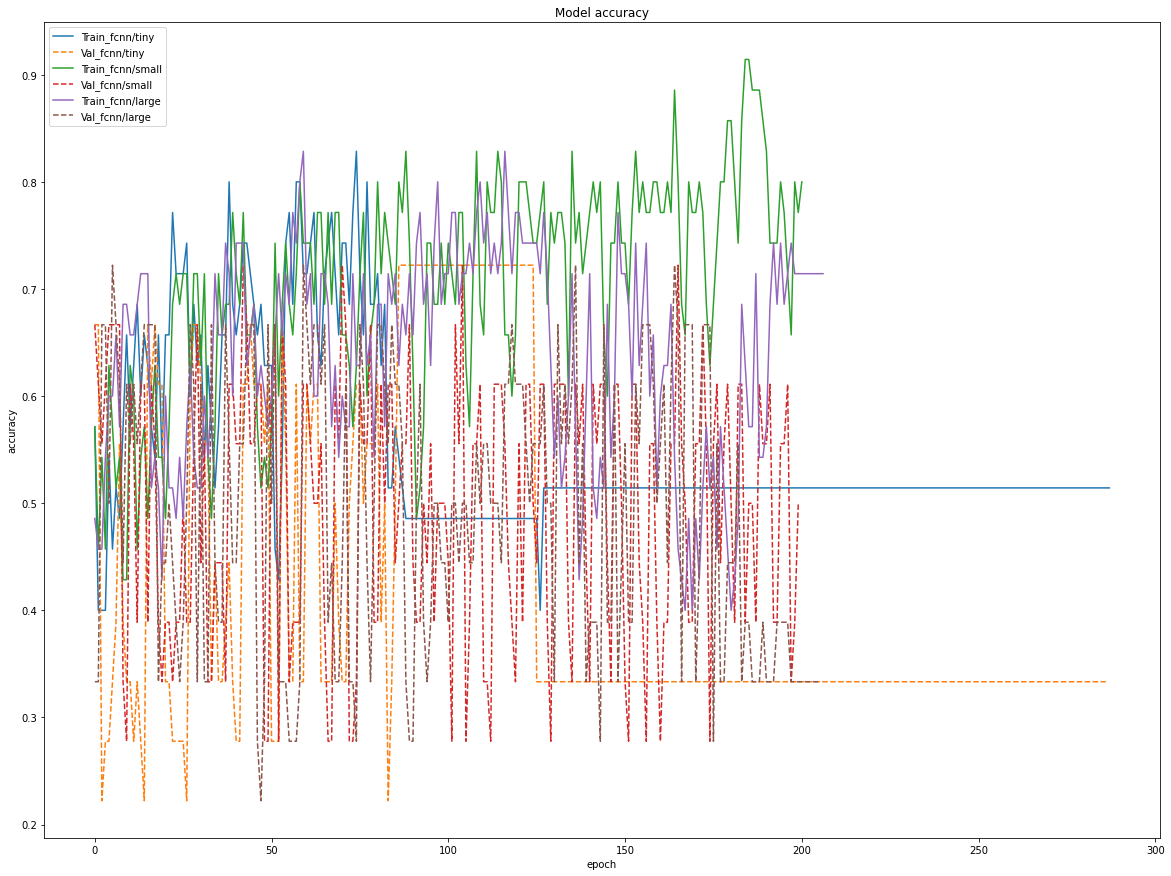

In [22]:
plot_report(size_histories)

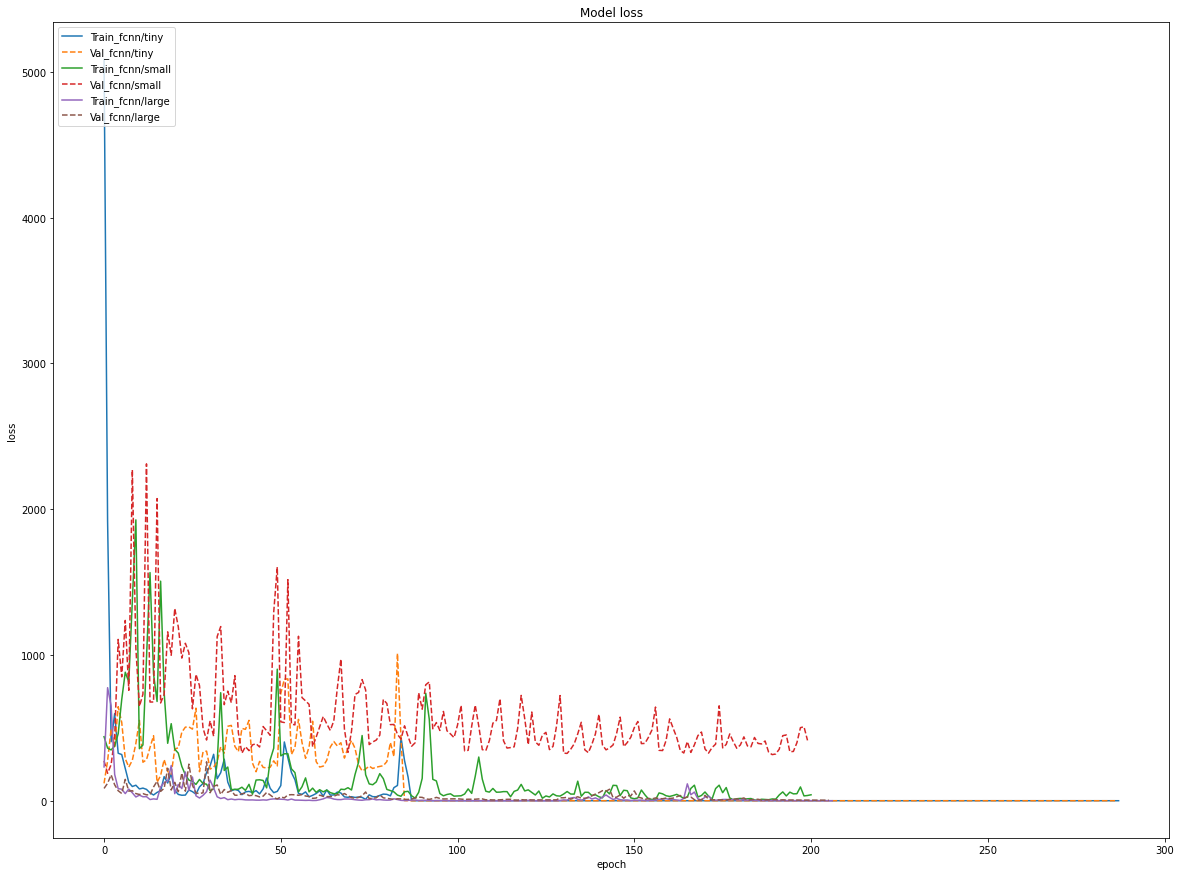

In [23]:
plot_report(size_histories, 'loss')

### Dropout

Although we got an accuracy of 0.75 looking at loss function chart is pretty obvious: There is overfiting. Now we have an overfitted NN let's make some adjustments to improve generalization capacity startin from dropout techniques.  

In [24]:
tiny_dropout = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/tiny/dropout'] = compile_and_fit(tiny_dropout, 
                                                      train_dataset,
                                                      test_dataset,
                                                      "fcnn/tiny/dropout", 
                                                      optimizer=tf.keras.optimizers.Adam(lr), 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATIO######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny/dropout'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny/dropout'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                262208    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 9

9/9 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5143 - val_loss: 2.1914 - val_accuracy: 0.2778
Epoch 108/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5143 - val_loss: 2.1914 - val_accuracy: 0.2778
Epoch 109/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5143 - val_loss: 2.1915 - val_accuracy: 0.2778
Epoch 110/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5143 - val_loss: 2.1915 - val_accuracy: 0.2778
Epoch 111/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5143 - val_loss: 2.1916 - val_accuracy: 0.2778
Epoch 112/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5143 - val_loss: 2.1916 - val_accuracy: 0.2778
Epoch 113/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5143 - val_loss: 2.1917 - val_accuracy: 0.2778
Epoch 114/1000
9/9 [=

Epoch 165/1000
9/9 [==============================] - 0s 8ms/step - loss: 0.6929 - accuracy: 0.5143 - val_loss: 2.1938 - val_accuracy: 0.2778
Epoch 166/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5143 - val_loss: 2.1939 - val_accuracy: 0.2778
Epoch 167/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5143 - val_loss: 2.1939 - val_accuracy: 0.2778
Epoch 168/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5143 - val_loss: 2.1939 - val_accuracy: 0.2778
Epoch 169/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5143 - val_loss: 2.1940 - val_accuracy: 0.2778
Epoch 170/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5143 - val_loss: 2.1940 - val_accuracy: 0.2778
Epoch 171/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5143 - val_loss: 2.1940 - val_accuracy: 0.2778
Epoch 

Epoch 223/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5143 - val_loss: 2.1953 - val_accuracy: 0.2778
Epoch 224/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5143 - val_loss: 2.1954 - val_accuracy: 0.2778
Epoch 225/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5143 - val_loss: 2.1954 - val_accuracy: 0.2778

#######################EVALUATIO######################
train acc: 0.6857143044471741
test acc: 0.7777777910232544


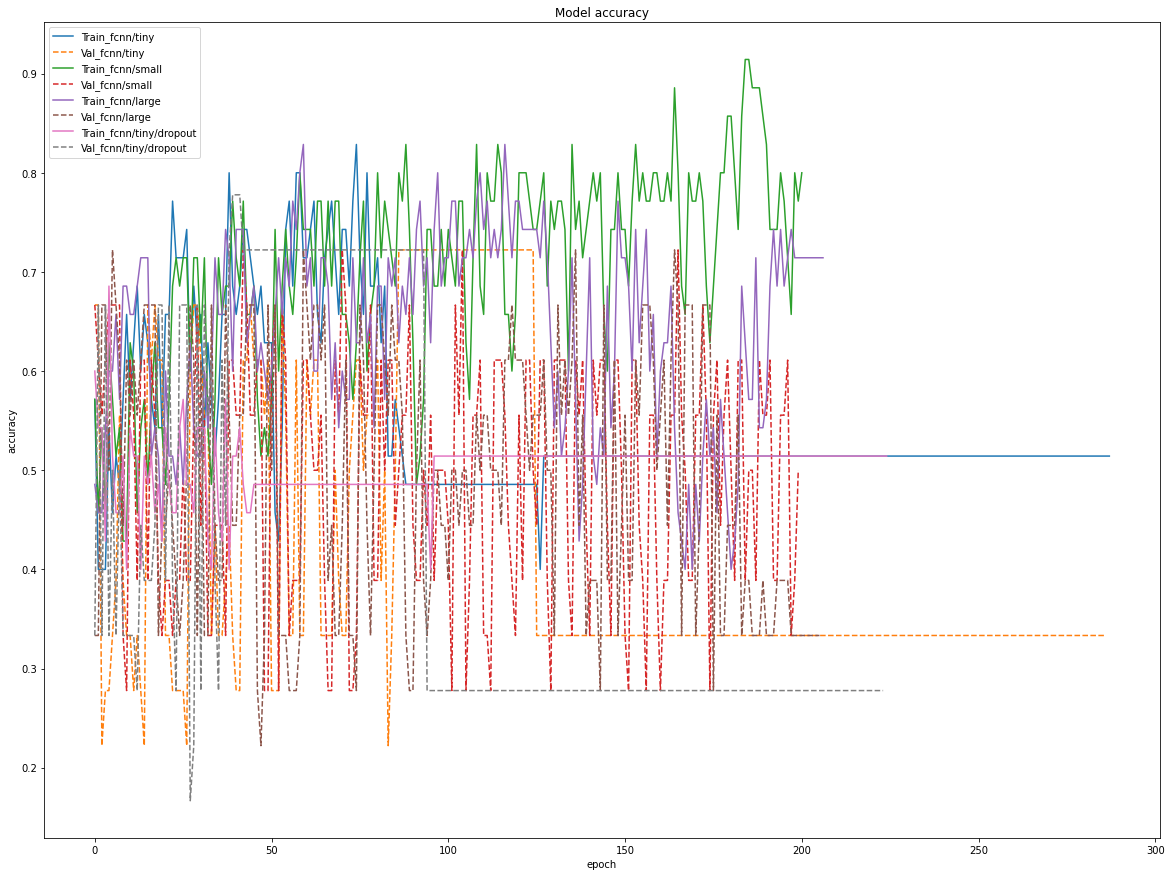

In [25]:
plot_report(size_histories)

Validation accuracy keeps improving more epoch with a total improvement from 0.75 to 0.81. Furthemore, the gap between training loss function and test loss function has been reduced.

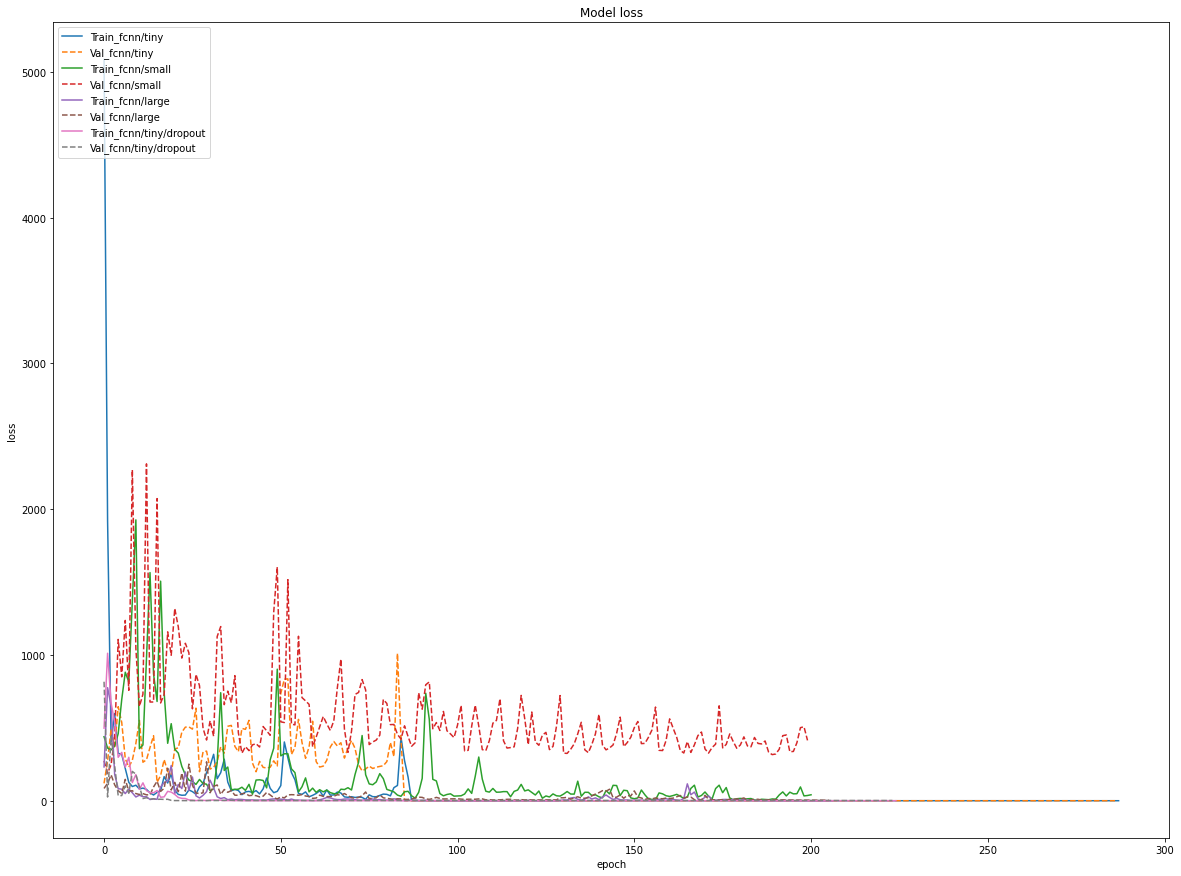

In [26]:
plot_report(size_histories, metric='loss')

### Kernel regularizer

In [27]:
# shutil.rmtree(logdir/'regularizers/tiny', ignore_errors=True)
# shutil.copytree(logdir/'fcnn/tiny', logdir/'regularizers/tiny')
regularizer_histories = {}
regularizer_histories['large'] = size_histories['fcnn/large']
regularizer_histories['dropout'] = size_histories['fcnn/tiny/dropout']

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

In tf.keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [28]:
l2_model = tf.keras.Sequential([
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(secondary_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(last_unit, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
regularizer_histories['l2'] = compile_and_fit(l2_model, train_dataset, 
                                              test_dataset, 
                                              optimizer=tf.keras.optimizers.Adam(lr),
                                              name="regularizers/l2")
# Evaluate the model on the test data using `evaluate`
print("\n#######################EVALUATIO######################")
print('test acc:', max(regularizer_histories['l2'].history["val_accuracy"]))
print('train acc:', max(regularizer_histories['l2'].history["accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 267,553
Trainable params: 267,553
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
9/9 [==============================] 

Epoch 51/1000
9/9 [==============================] - 0s 3ms/step - loss: 11.0537 - accuracy: 0.5429 - val_loss: 8.3851 - val_accuracy: 0.7222
Epoch 52/1000
9/9 [==============================] - 0s 3ms/step - loss: 11.1052 - accuracy: 0.5429 - val_loss: 28.7304 - val_accuracy: 0.3333
Epoch 53/1000
9/9 [==============================] - 0s 3ms/step - loss: 5.7861 - accuracy: 0.5714 - val_loss: 19.7447 - val_accuracy: 0.3889
Epoch 54/1000
9/9 [==============================] - 0s 3ms/step - loss: 5.8433 - accuracy: 0.6571 - val_loss: 27.5804 - val_accuracy: 0.4444
Epoch 55/1000
9/9 [==============================] - 0s 3ms/step - loss: 5.2518 - accuracy: 0.7429 - val_loss: 7.9696 - val_accuracy: 0.6111
Epoch 56/1000
9/9 [==============================] - 0s 3ms/step - loss: 3.4277 - accuracy: 0.6286 - val_loss: 15.5840 - val_accuracy: 0.3889
Epoch 57/1000
9/9 [==============================] - 0s 3ms/step - loss: 4.3007 - accuracy: 0.6286 - val_loss: 36.2466 - val_accuracy: 0.3889
Epoch 

Epoch 166/1000
9/9 [==============================] - 0s 3ms/step - loss: 2.4158 - accuracy: 0.5429 - val_loss: 3.0394 - val_accuracy: 0.6667
Epoch 167/1000
9/9 [==============================] - 0s 3ms/step - loss: 2.9952 - accuracy: 0.4857 - val_loss: 2.8174 - val_accuracy: 0.6667
Epoch 168/1000
9/9 [==============================] - 0s 3ms/step - loss: 4.5558 - accuracy: 0.4000 - val_loss: 5.9559 - val_accuracy: 0.3333
Epoch 169/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.4142 - accuracy: 0.6571 - val_loss: 1.0776 - val_accuracy: 0.6667
Epoch 170/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.2826 - accuracy: 0.4857 - val_loss: 1.0412 - val_accuracy: 0.6667
Epoch 171/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0747 - accuracy: 0.4857 - val_loss: 1.0561 - val_accuracy: 0.6111
Epoch 172/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0736 - accuracy: 0.4857 - val_loss: 1.0518 - val_accuracy: 0.6667
Epoch 

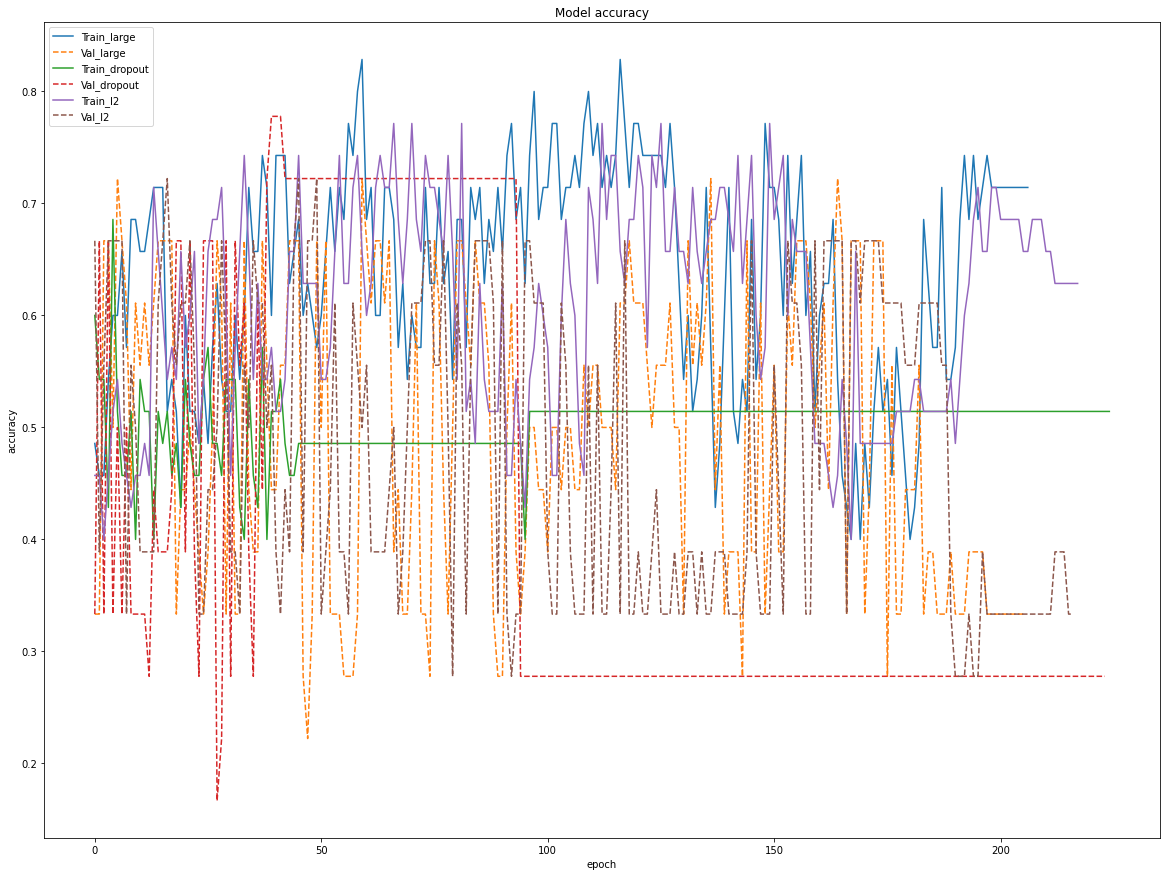

In [29]:
plot_report(regularizer_histories, 'accuracy')

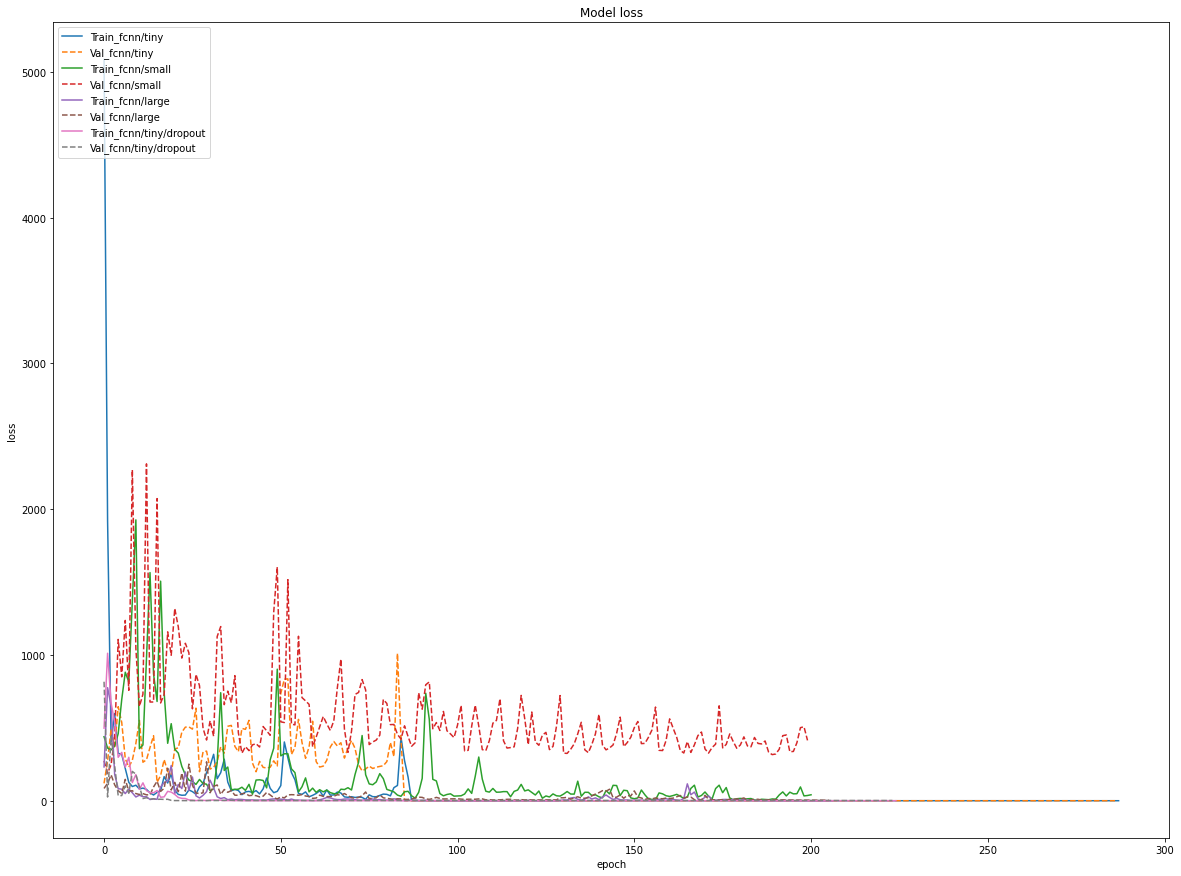

In [30]:
plot_report(size_histories, 'loss')

Now let's see what happens combining both techniques

In [31]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
combined_model = tf.keras.Sequential([
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(secondary_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(last_unit, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    tf.keras.layers.Dropout(dr),
    layers.Dense(num_classes, activation=tf.nn.sigmoid)
])

tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
regularizer_histories['combined'] = compile_and_fit(combined_model, train_dataset, test_dataset, "regularizers/combined",
                                                   optimizer=get_optimizer())

# Evaluate the model on the test data using `evaluate`
print()
print('test acc:', max(regularizer_histories['combined'].history["val_accuracy"]))
print('train acc:', max(regularizer_histories['combined'].history["accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 267,553
Trainable params: 267,553
Non-trai

9/9 [==============================] - 0s 3ms/step - loss: 1.1279 - accuracy: 0.4857 - val_loss: 3.9136 - val_accuracy: 0.6667
Epoch 109/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.1096 - accuracy: 0.4000 - val_loss: 3.9666 - val_accuracy: 0.2778
Epoch 110/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0840 - accuracy: 0.5429 - val_loss: 3.9573 - val_accuracy: 0.6667
Epoch 111/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.1217 - accuracy: 0.4571 - val_loss: 4.0191 - val_accuracy: 0.2778
Epoch 112/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0890 - accuracy: 0.4857 - val_loss: 4.0173 - val_accuracy: 0.6667
Epoch 113/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.0949 - accuracy: 0.4857 - val_loss: 4.0253 - val_accuracy: 0.6667
Epoch 114/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.1030 - accuracy: 0.4857 - val_loss: 4.0664 - val_accuracy: 0.2778
Epoch 115/1000
9/9 [=

Epoch 166/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.1135 - accuracy: 0.4286 - val_loss: 4.3874 - val_accuracy: 0.6667
Epoch 167/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0843 - accuracy: 0.4286 - val_loss: 4.4940 - val_accuracy: 0.2778
Epoch 168/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.1125 - accuracy: 0.5143 - val_loss: 4.5428 - val_accuracy: 0.2778
Epoch 169/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0918 - accuracy: 0.5143 - val_loss: 4.4831 - val_accuracy: 0.2778
Epoch 170/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0868 - accuracy: 0.5143 - val_loss: 4.4556 - val_accuracy: 0.2778
Epoch 171/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0769 - accuracy: 0.5143 - val_loss: 4.4314 - val_accuracy: 0.6667
Epoch 172/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0917 - accuracy: 0.4571 - val_loss: 4.4528 - val_accuracy: 0.2778
Epoch 

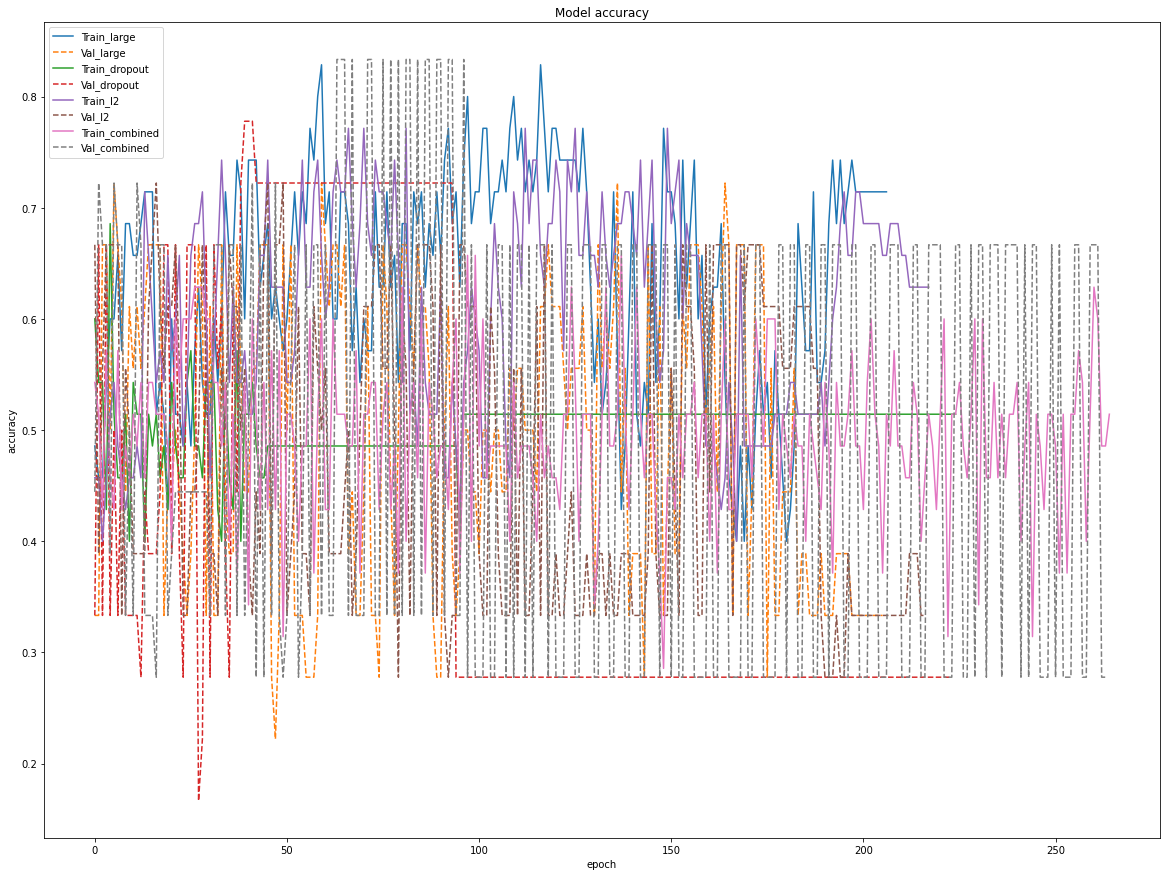

In [32]:
plot_report(regularizer_histories, 'accuracy')

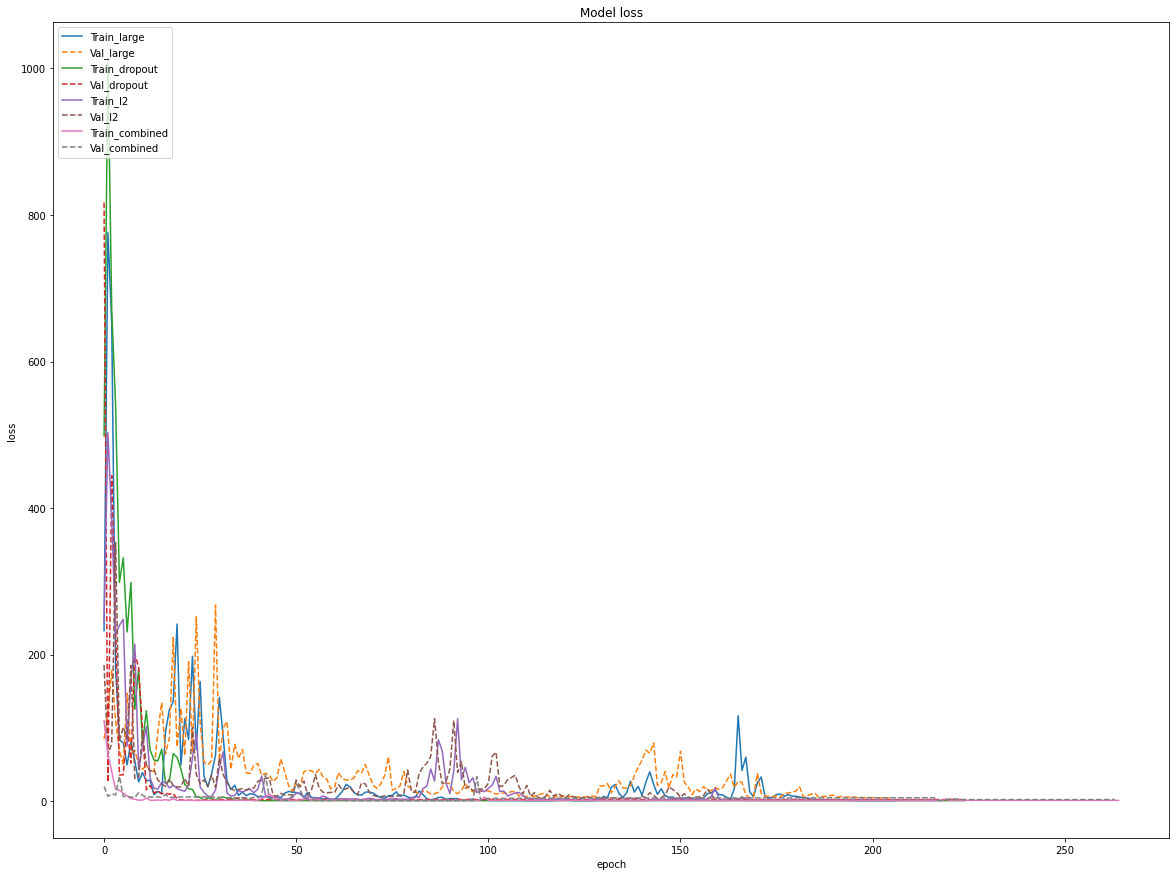

In [33]:
plot_report(regularizer_histories, 'loss')

## Batch Normalization

Batch normalization (also known as batch norm) is a method used to make artificial neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling. It was proposed by Sergey Ioffe and Christian Szegedy in 2015.

[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

[Tensorflow implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)


In [34]:
batch_histories = {}
batch_histories['large'] = size_histories['fcnn/large']
batch_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [35]:
small_batch = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
batch_histories['fcnn/small/batch'] = compile_and_fit(small_batch, 
                                                      train_dataset,
                                                      test_dataset,
                                                      "fcnn/small/batch", 
                                                      optimizer=tf.keras.optimizers.Adam(lr), 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(batch_histories['fcnn/small/batch'].history["accuracy"]))
print('test acc:', max(batch_histories['fcnn/small/batch'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                262208    
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 batch_normalization_2 (Batc  (None, 16)               6

9/9 [==============================] - 0s 5ms/step - loss: 0.1129 - accuracy: 0.9714 - val_loss: 6021.9048 - val_accuracy: 0.3889
Epoch 102/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0865 - accuracy: 0.9714 - val_loss: 6082.9917 - val_accuracy: 0.3889
Epoch 103/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0846 - accuracy: 0.9714 - val_loss: 6152.0767 - val_accuracy: 0.3889
Epoch 104/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0699 - accuracy: 1.0000 - val_loss: 6241.6816 - val_accuracy: 0.3889
Epoch 105/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0636 - accuracy: 1.0000 - val_loss: 6345.5430 - val_accuracy: 0.3333
Epoch 106/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0902 - accuracy: 1.0000 - val_loss: 6423.5527 - val_accuracy: 0.3333
Epoch 107/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1322 - accuracy: 0.9714 - val_loss: 6434.6577 - val_accuracy: 0.4444


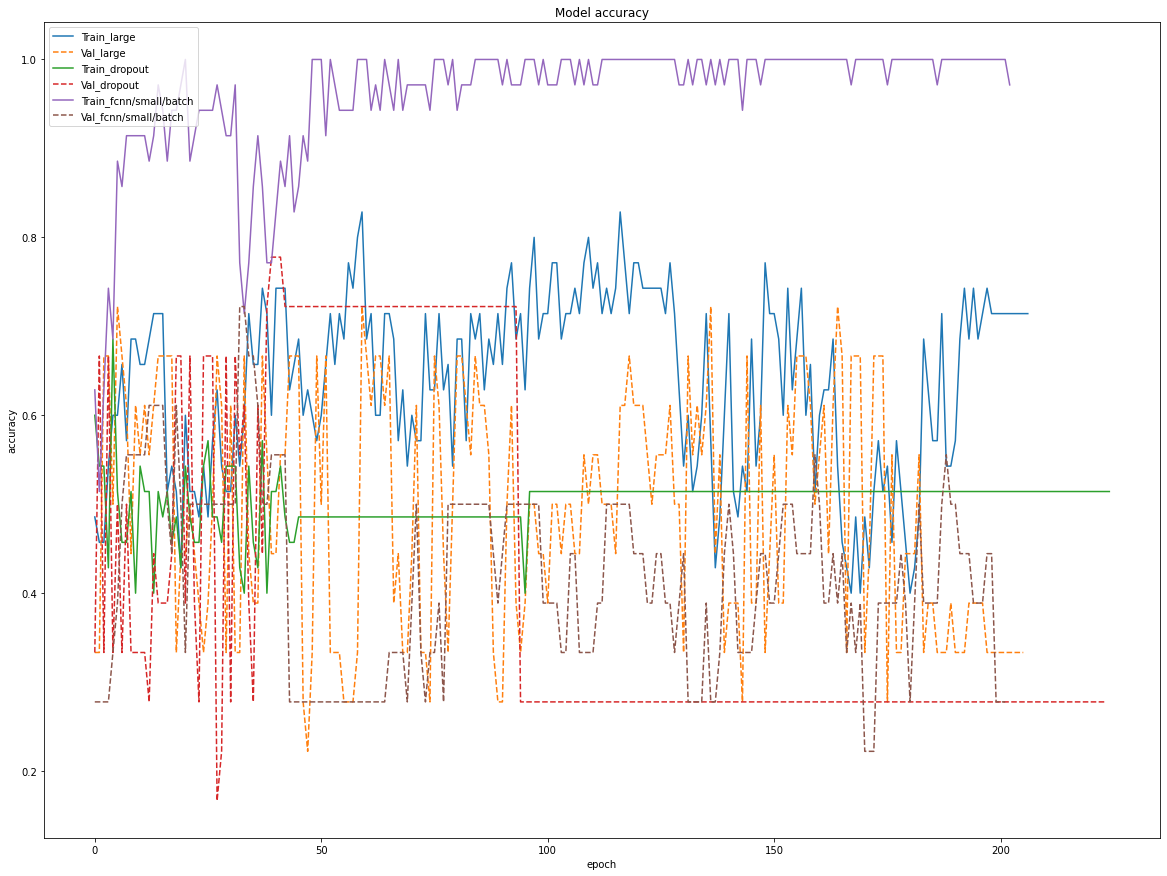

In [36]:
plot_report(batch_histories, 'accuracy')

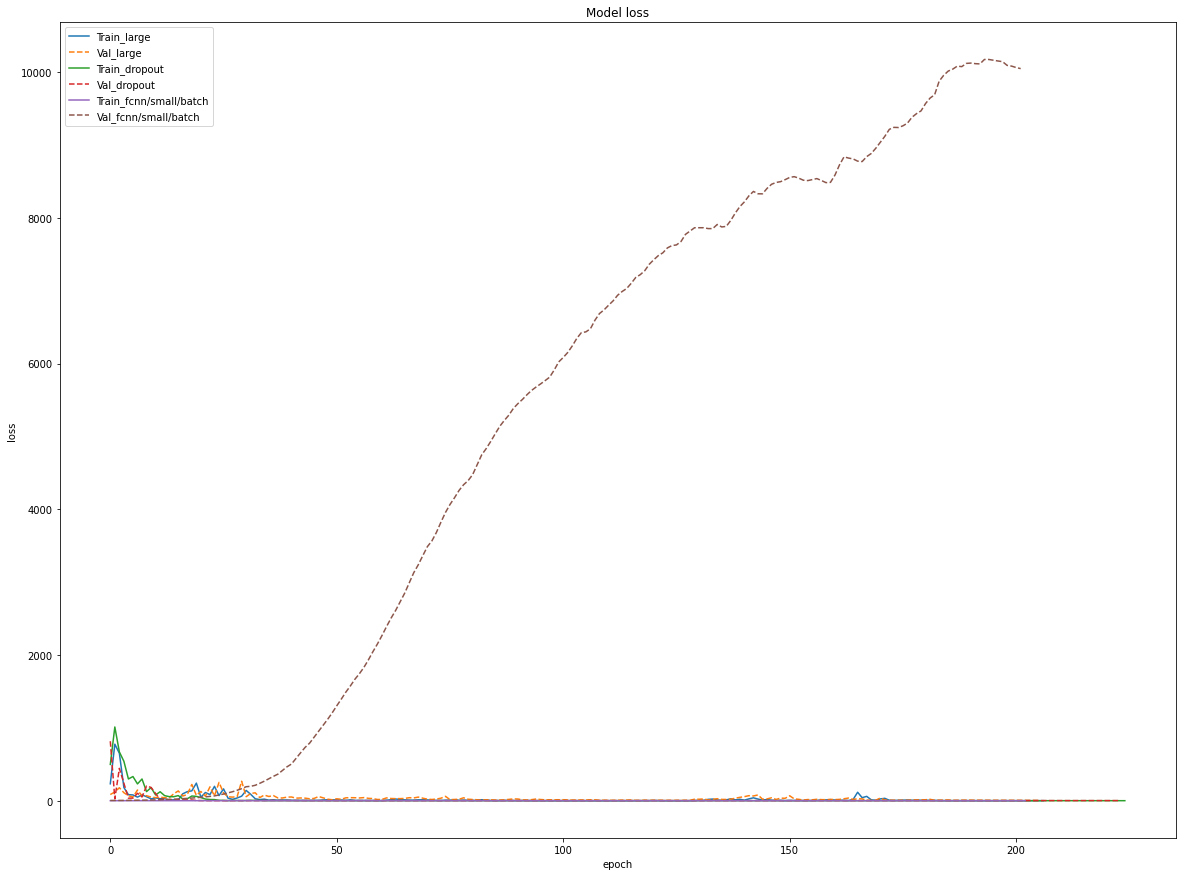

In [37]:
plot_report(batch_histories, 'loss')

## LSTM-FCNN

Univariate time series classification model, the Long Short Term Memory Fully Convolutional Network (LSTM-FCN) to capture time related information

In [24]:
lstm_histories = {}
lstm_histories['large'] = size_histories['fcnn/large']
lstm_histories['dropout'] = size_histories['fcnn/tiny/dropout']

NameError: name 'size_histories' is not defined

In [19]:
lstm_units=24
lstm_tiny_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[num_features,]),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)
                        ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
#     tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/tiny'] = compile_and_fit(lstm_tiny_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                                        lr=1e-4,
#                                                                        multiplier=10),
                                               name="lstm/tiny")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('test acc:', max(lstm_histories['lstm/tiny'].history["val_accuracy"]))
print('train acc:', max(lstm_histories['lstm/tiny'].history["accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 4096)           0         
                                                                 
 lstm (LSTM)                 (None, 24)                395616    
                                                                 
 batch_normalization (BatchN  (None, 24)               96        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 395,939
Trainable params: 395,891
Non-trainable params: 48
_________________________________________________

9/9 [==============================] - 0s 4ms/step - loss: 1.0234 - accuracy: 0.5429 - val_loss: 0.8844 - val_accuracy: 0.7222
Epoch 52/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0233 - accuracy: 0.5429 - val_loss: 0.9986 - val_accuracy: 0.7222
Epoch 53/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0145 - accuracy: 0.5429 - val_loss: 0.8793 - val_accuracy: 0.7222
Epoch 54/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0235 - accuracy: 0.5429 - val_loss: 0.9414 - val_accuracy: 0.2222
Epoch 55/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0236 - accuracy: 0.5429 - val_loss: 0.9385 - val_accuracy: 0.2222
Epoch 56/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.0236 - accuracy: 0.5429 - val_loss: 0.9364 - val_accuracy: 0.2222
Epoch 57/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.0235 - accuracy: 0.5429 - val_loss: 0.9349 - val_accuracy: 0.2222
Epoch 58/1000
9/9 [========

9/9 [==============================] - 0s 4ms/step - loss: 1.0213 - accuracy: 0.5429 - val_loss: 0.8596 - val_accuracy: 0.7222
Epoch 110/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0212 - accuracy: 0.5429 - val_loss: 0.8493 - val_accuracy: 0.7222
Epoch 111/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.0211 - accuracy: 0.5429 - val_loss: 0.8412 - val_accuracy: 0.7222
Epoch 112/1000
9/9 [==============================] - 0s 10ms/step - loss: 1.0209 - accuracy: 0.5429 - val_loss: 0.8351 - val_accuracy: 0.7222
Epoch 113/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0208 - accuracy: 0.5429 - val_loss: 0.8307 - val_accuracy: 0.7222
Epoch 114/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0207 - accuracy: 0.5429 - val_loss: 0.8276 - val_accuracy: 0.7222
Epoch 115/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0206 - accuracy: 0.5429 - val_loss: 0.8256 - val_accuracy: 0.7222
Epoch 116/1000
9/9 [

Epoch 167/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.0193 - accuracy: 0.5429 - val_loss: 1.2448 - val_accuracy: 0.7222
Epoch 168/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.0277 - accuracy: 0.5429 - val_loss: 1.5973 - val_accuracy: 0.7222
Epoch 169/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.0201 - accuracy: 0.5429 - val_loss: 0.8602 - val_accuracy: 0.7222
Epoch 170/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.0204 - accuracy: 0.5429 - val_loss: 0.8369 - val_accuracy: 0.7222
Epoch 171/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.0210 - accuracy: 0.5429 - val_loss: 0.8175 - val_accuracy: 0.7222
Epoch 172/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0210 - accuracy: 0.5429 - val_loss: 0.8035 - val_accuracy: 0.7222
Epoch 173/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.0208 - accuracy: 0.5429 - val_loss: 0.7914 - val_accuracy: 0.7222
Epoch 

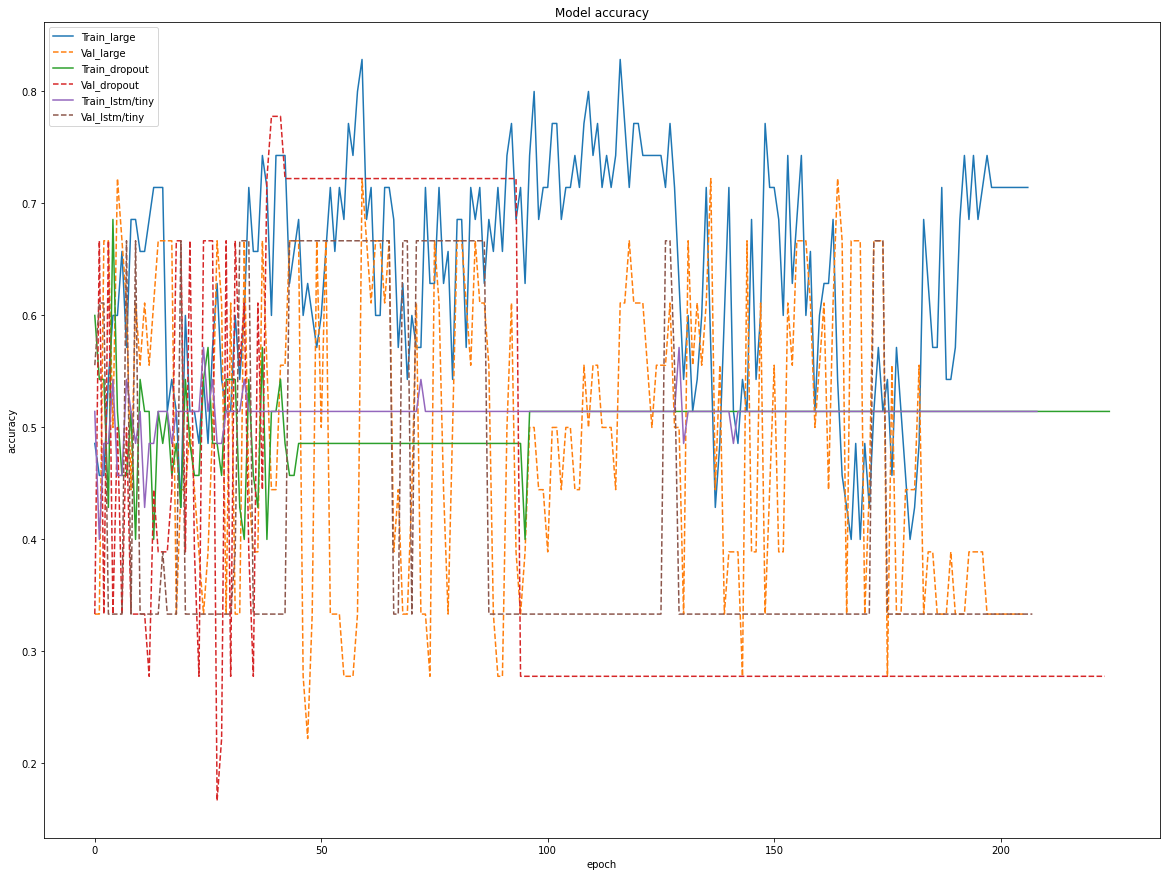

In [40]:
plot_report(lstm_histories, 'accuracy')

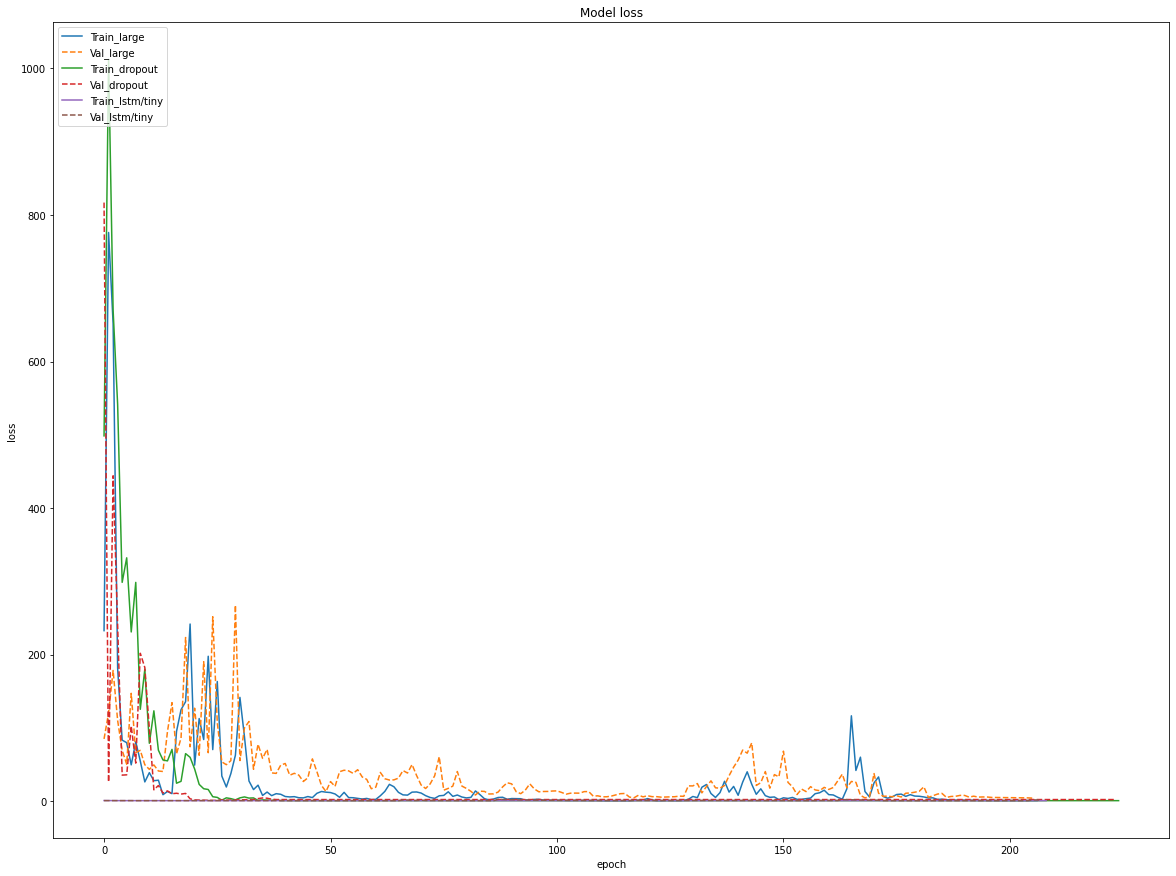

In [41]:
plot_report(lstm_histories, 'loss')

In [27]:
lstm_small_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[num_features,]),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/small'] = compile_and_fit(lstm_small_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                                        lr=1e-4,
#                                                                        multiplier=10),
                                               name="lstm/small")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/small'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/small'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 4096)           0         
                                                                 
 lstm (LSTM)                 (None, 1, 64)             1065216   
                                                                 
 batch_normalization (BatchN  (None, 1, 64)            256       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 8)                 5

Epoch 48/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.1085 - accuracy: 0.4857 - val_loss: 1.0440 - val_accuracy: 0.6667
Epoch 49/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.1090 - accuracy: 0.4857 - val_loss: 1.0320 - val_accuracy: 0.6667
Epoch 50/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.1261 - accuracy: 0.4857 - val_loss: 1.0247 - val_accuracy: 0.6667
Epoch 51/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.1163 - accuracy: 0.4857 - val_loss: 1.1264 - val_accuracy: 0.6667
Epoch 52/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.1227 - accuracy: 0.4857 - val_loss: 0.9575 - val_accuracy: 0.6667
Epoch 53/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.1018 - accuracy: 0.4857 - val_loss: 0.9587 - val_accuracy: 0.6667
Epoch 54/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.0996 - accuracy: 0.4857 - val_loss: 0.9600 - val_accuracy: 0.6667
Epoch 55/1000

9/9 [==============================] - 0s 5ms/step - loss: 1.0314 - accuracy: 0.5429 - val_loss: 2.5720 - val_accuracy: 0.6667
Epoch 107/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.2147 - accuracy: 0.4571 - val_loss: 2.4367 - val_accuracy: 0.6667
Epoch 108/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.0869 - accuracy: 0.4857 - val_loss: 2.3082 - val_accuracy: 0.6667
Epoch 109/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.0667 - accuracy: 0.4857 - val_loss: 2.2089 - val_accuracy: 0.6667
Epoch 110/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.1001 - accuracy: 0.4857 - val_loss: 2.1471 - val_accuracy: 0.6667
Epoch 111/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.0928 - accuracy: 0.4857 - val_loss: 2.0189 - val_accuracy: 0.6667
Epoch 112/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.0899 - accuracy: 0.4857 - val_loss: 2.5890 - val_accuracy: 0.6667
Epoch 113/1000
9/9 [=

Epoch 164/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.1050 - accuracy: 0.4857 - val_loss: 1.8578 - val_accuracy: 0.6667
Epoch 165/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.0636 - accuracy: 0.4857 - val_loss: 1.7732 - val_accuracy: 0.6667
Epoch 166/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.0887 - accuracy: 0.4857 - val_loss: 1.6075 - val_accuracy: 0.6667
Epoch 167/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.1000 - accuracy: 0.4857 - val_loss: 1.5135 - val_accuracy: 0.6667
Epoch 168/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.0917 - accuracy: 0.4857 - val_loss: 1.4323 - val_accuracy: 0.6667
Epoch 169/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.0814 - accuracy: 0.4857 - val_loss: 1.3608 - val_accuracy: 0.6667
Epoch 170/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.0825 - accuracy: 0.4857 - val_loss: 1.2995 - val_accuracy: 0.6667
Epoch 

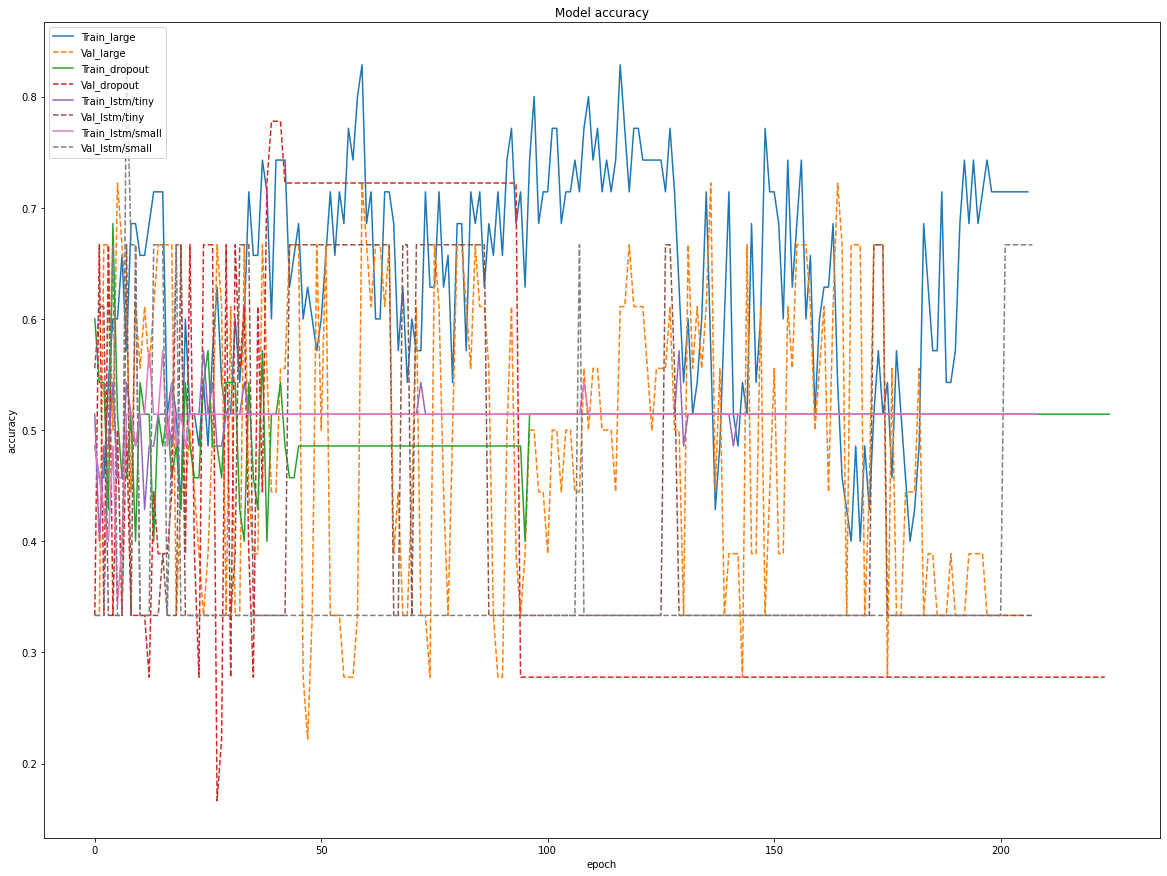

In [43]:
plot_report(lstm_histories, 'accuracy')

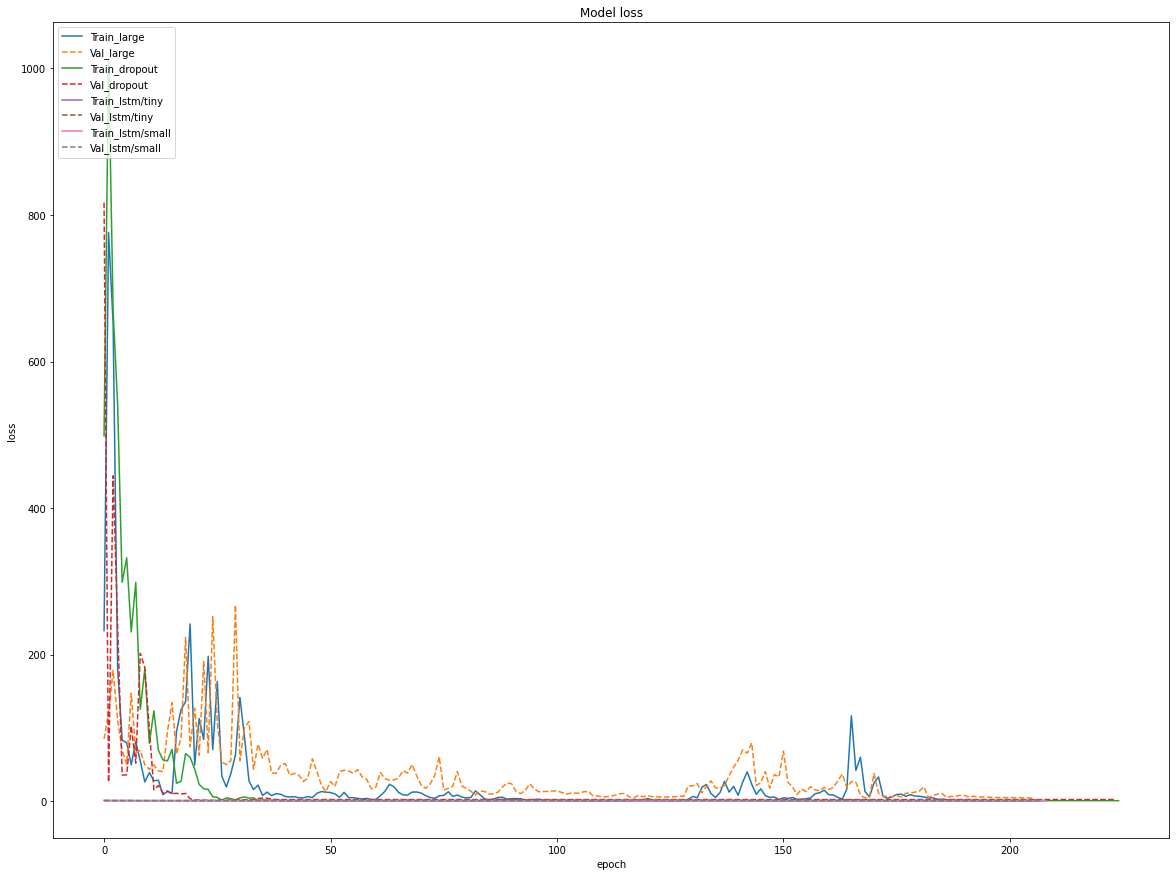

In [44]:
plot_report(lstm_histories, 'loss')

In [45]:
lstm_units=256
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_large_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[num_features,]),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/large'] = compile_and_fit(lstm_large_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                lr=1e-4,
#                                                multiplier=10), 
                                                name="lstm/large")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/large'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/large'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 4096)           0         
                                                                 
 lstm (LSTM)                 (None, 1, 256)            4457472   
                                                                 
 batch_normalization (BatchN  (None, 1, 256)           1024      
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 64)                1

9/9 [==============================] - 0s 7ms/step - loss: 0.8655 - accuracy: 0.6286 - val_loss: 1.0216 - val_accuracy: 0.6111
Epoch 98/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.9206 - accuracy: 0.6286 - val_loss: 1.1674 - val_accuracy: 0.6111
Epoch 99/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.9166 - accuracy: 0.5714 - val_loss: 1.6354 - val_accuracy: 0.6111
Epoch 100/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.8336 - accuracy: 0.6000 - val_loss: 9.9083 - val_accuracy: 0.3333
Epoch 101/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.9066 - accuracy: 0.6000 - val_loss: 7.9439 - val_accuracy: 0.3333
Epoch 102/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.8859 - accuracy: 0.7143 - val_loss: 5.5722 - val_accuracy: 0.3889
Epoch 103/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.8301 - accuracy: 0.7143 - val_loss: 3.6525 - val_accuracy: 0.3889
Epoch 104/1000
9/9 [===

Epoch 155/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.9061 - accuracy: 0.6286 - val_loss: 8.9473 - val_accuracy: 0.6667
Epoch 156/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.8879 - accuracy: 0.7429 - val_loss: 2.8270 - val_accuracy: 0.6667
Epoch 157/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.9345 - accuracy: 0.6857 - val_loss: 4.9407 - val_accuracy: 0.7222
Epoch 158/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.8646 - accuracy: 0.7143 - val_loss: 29.2990 - val_accuracy: 0.3333
Epoch 159/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.8872 - accuracy: 0.6857 - val_loss: 28.1435 - val_accuracy: 0.3333
Epoch 160/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.9769 - accuracy: 0.5714 - val_loss: 24.5198 - val_accuracy: 0.3333
Epoch 161/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.9427 - accuracy: 0.6000 - val_loss: 20.2353 - val_accuracy: 0.3333
Ep

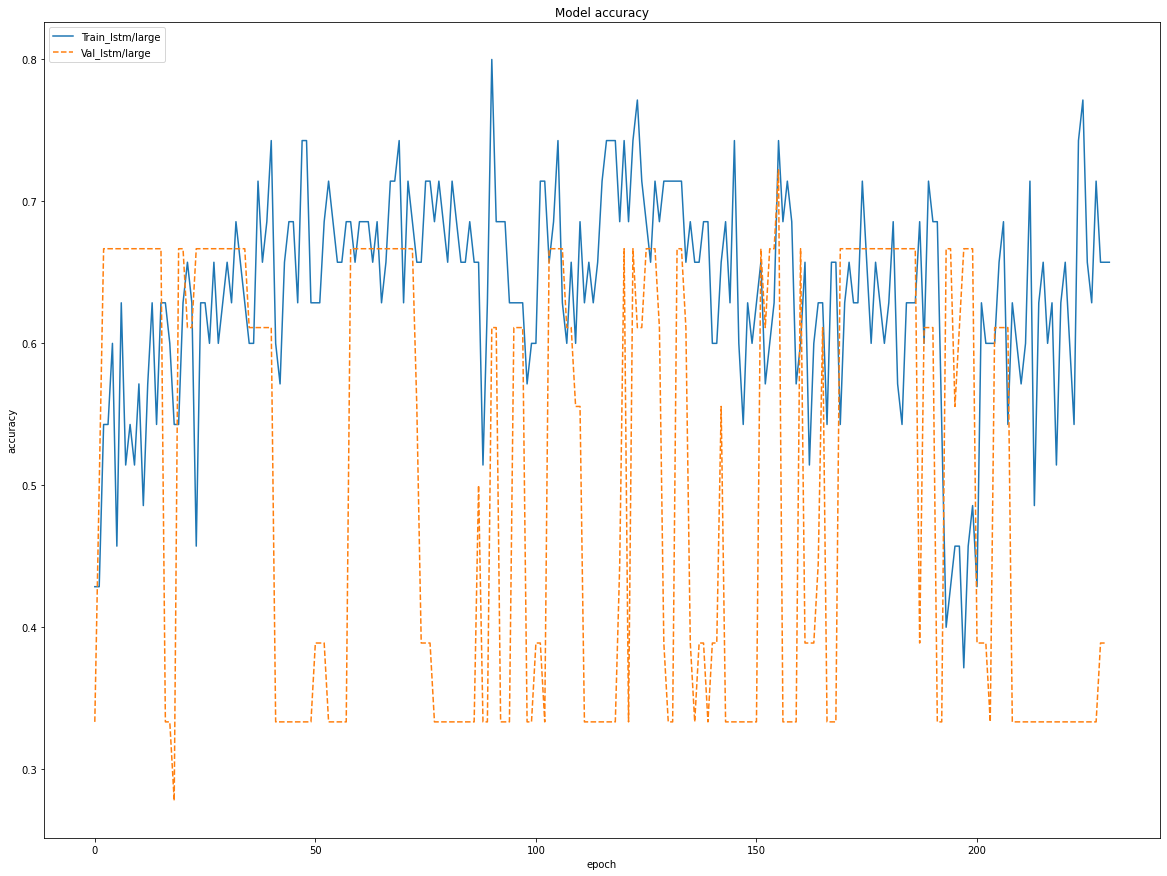

In [46]:
plot_report({'lstm/large':lstm_histories['lstm/large']}, 'accuracy')

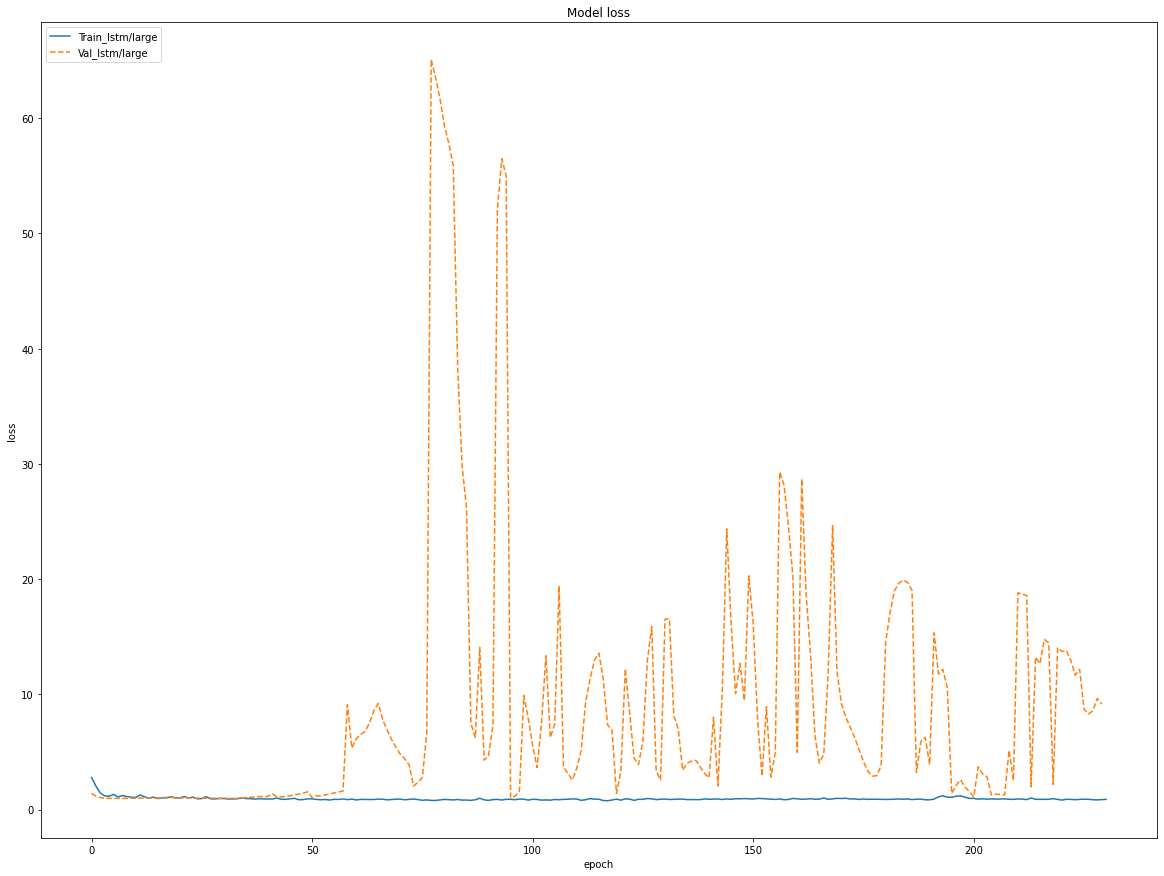

In [47]:
plot_report({'lstm/large':lstm_histories['lstm/large']}, 'loss')